# baseline 모델 생성 및 평가

   ## 유통매장 수요량 예측

* 비즈니스 현황
    * 고객사는 A 유통회사의 a 매장 입니다.
    * a 매장에서 주력상품인 a01에 대한 재고 최적화를 위해 수요량을 예측하고자 합니다.
    * 최근 경쟁사의 매장이 가까운 거리에 오픈하였고, 유사한 상품에 대한 공격적인 마케팅을 펼치고 있습니다.
* 발주 최적화를 위한 수요량 예측
    * 일마감 이후, 발주량을 결정할 때, 예측된 수요량이 필요합니다.
    * 발주후 입고까지는 2일의 기간이 걸립니다.
    * 예를 들면
        * 2019년 6월 1일 저녁 10시 일마감 직후, 6월 3일의 수요량을 예측해야 합니다.
        * 예측된 수요량과 현 재고, 안전재고량 등을 감안하여 발주량은 결정되고,
        * 발주 수량은 6월3일 새벽에 매장에 입고되어 6월3일에 판매할 수 있습니다.
* 발주 최적화를 위한 수요량 예측 : 2일후의 판매량을 예측

![](https://www.artefact.com//wp-content/uploads/2021/08/GettyImages-1295864156-scaled.jpg)

# 1.환경 준비

## (1) Import Packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import scipy.stats as spst
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import *

import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.filterwarnings(action='ignore')
warnings.simplefilter('ignore', ConvergenceWarning)

## (2) Data Loading

In [ ]:
path = 'https://raw.githubusercontent.com/DA4BAM/dataset/master/retail_demand2.csv'
data = pd.read_csv(path)
data = data.loc[data['date'].between('2013-06-01', '2015-03-02')].reset_index(drop = True)
data

In [3]:
data.to_csv('data.csv')

* 변수 설명

    * date : 날짜
    * item : 상품코드 (여기서는 한가지 상품만 있음)
    * sales : A유통회사 a 매장 판매량 ==> target
    * tot_sales : A유통회사 전체 판매량
    * comp_sales : 인근에 위치한 B유통회사 b 매장 판매량

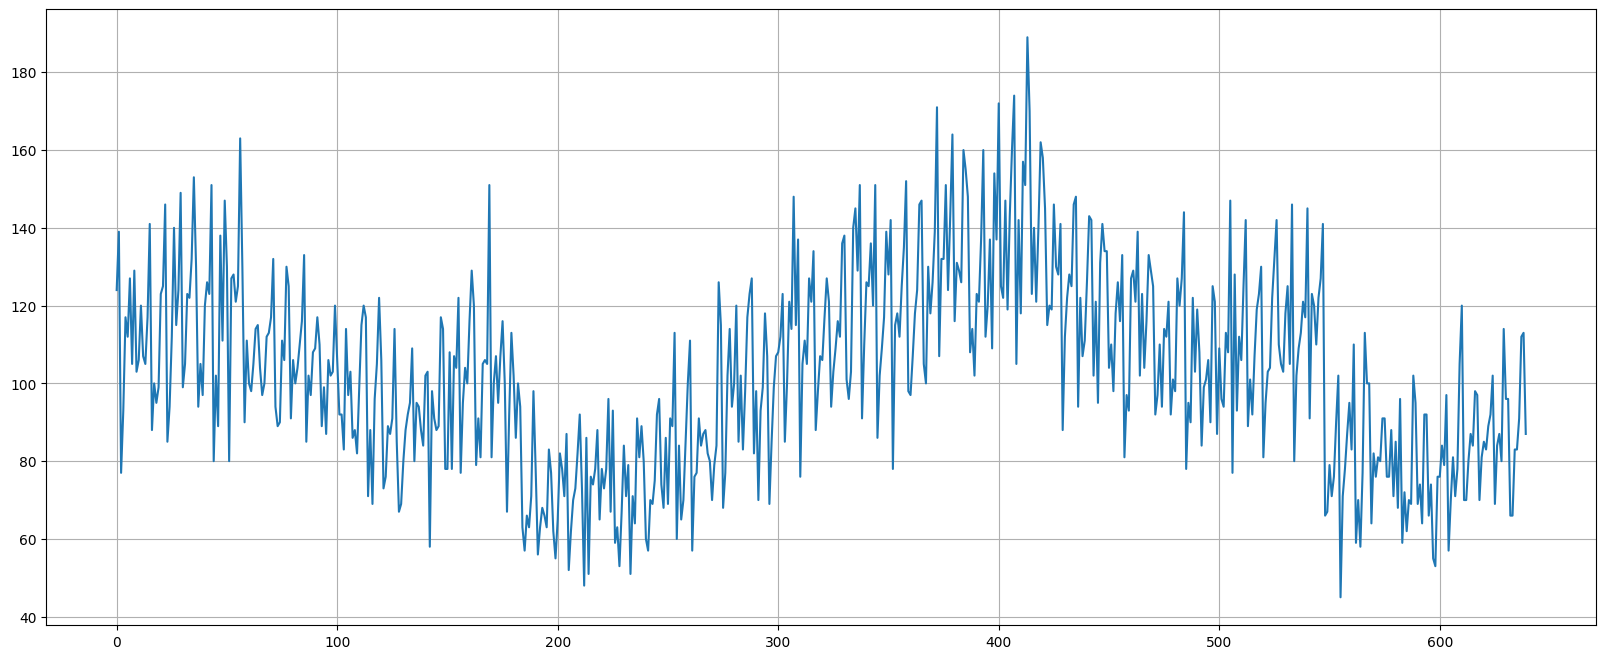

In [ ]:
plt.figure(figsize = (20,8))
plt.plot(data['sales'])
plt.grid()
plt.show()

## (3) 함수 생성

* 결과 시각화

In [ ]:
def plot_model_result(y_train, y_val, pred) :
    pred = pd.Series(pred, index = y_val.index)

    # 전체 시각화
    plt.figure(figsize = (20,12))
    plt.subplot(2,1,1)
    plt.plot(y_train, label = 'train')
    plt.plot(y_val, label = 'val')
    plt.plot(pred, label = 'pred')
    plt.legend()
    plt.grid()

    plt.subplot(2,1,2)
    plt.plot(y_val, label = 'val')
    plt.plot(pred, label = 'pred')
    plt.legend()
    plt.grid()

    plt.show()

* 잔차분석

In [ ]:
def residual_diag(residuals, lags = 30) :
    print('* 정규성 검정(> 0.05) : ', round(spst.shapiro(residuals)[1],5))
    print('* 정상성 검정(< 0.05) : ', round(sm.tsa.stattools.adfuller(residuals)[1],5))
    print('* 자기상관성 확인(ACF, PACF)')
    fig,ax = plt.subplots(1,2, figsize = (15,5))
    plot_acf(residuals, lags = lags, ax = ax[0])
    plot_pacf(residuals, lags = lags, ax = ax[1])
    plt.show()

# 2.기본 전처리

## (1) y 만들기

* 사전 관찰(look-ahead) : 미래의 어떤 사실을 안다는 뜻
* 사전 관찰 문제 :
    * 데이터를 통해 실제로 알아야 하는 시점보다 더 일찍 미래에 대한 사실을 알게 되는 문제.  
    * 사전관찰 문제가 있는 채로 모델링을 하게 되면, 놀라운 성능의 모델이 만들어짐. --> 그러나 실제로는 불가능한 상황.

* 그래서 y를 만들때 사전관찰문제가 발생되지 않도록 해야 함.
    * 예제는 **2일 후의 수요량**을 예측하려고 합니다.

* 2일 후 수요량을 예측하려면, y를 어떻게 만들어야 할까요?

In [ ]:
data['target'] = data['sales'].shift(-2)
data.head()

,date,item,sales,tot_sales,comp_sales,target
0,2013-06-01,28,124,1016,80,77.0
1,2013-06-02,28,139,1019,93,93.0
2,2013-06-03,28,77,676,65,117.0
3,2013-06-04,28,93,764,80,112.0
4,2013-06-05,28,117,818,80,127.0


In [ ]:
# 마지막 두 행은 삭제
data = data.iloc[:-2]

In [ ]:
data.tail()

,date,item,sales,tot_sales,comp_sales,target
633,2015-02-24,28,66,603,71,83.0
634,2015-02-25,28,83,622,61,91.0
635,2015-02-26,28,83,611,48,112.0
636,2015-02-27,28,91,696,74,113.0
637,2015-02-28,28,112,774,77,87.0


## (2) 데이터 분할

### 1) x, y 나누기

In [ ]:
target = 'target'

x = data.drop([target,'date','item'], axis = 1)
y = data[target]

### 2) train, val 분할
* 최근 30일 데이터를 Validation Set으로 지정

In [ ]:
val_size = 30
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size = val_size, shuffle = False)

# 3.Baseline 모델 생성

## (1) 모델링

In [ ]:
# 아래 코드는 그대로 사용하세요.
model1 = sm.tsa.SARIMAX(y_train, order=(1,1,1)).fit()

In [ ]:
# AIC 평가
model1.aic

## (2) 검증

In [ ]:
pred1 = model1.forecast(val_size)

print('MAE  : ', mean_absolute_error(y_val, pred1)  )
print('MAPE : ', mean_absolute_percentage_error(y_val, pred1) )
print('R2   : ', r2_score(y_val, pred1) )

MAE  :  12.977607875982805
MAPE :  0.13879413102945512
R2   :  -0.3517886914927839


## (3) 결과 시각화

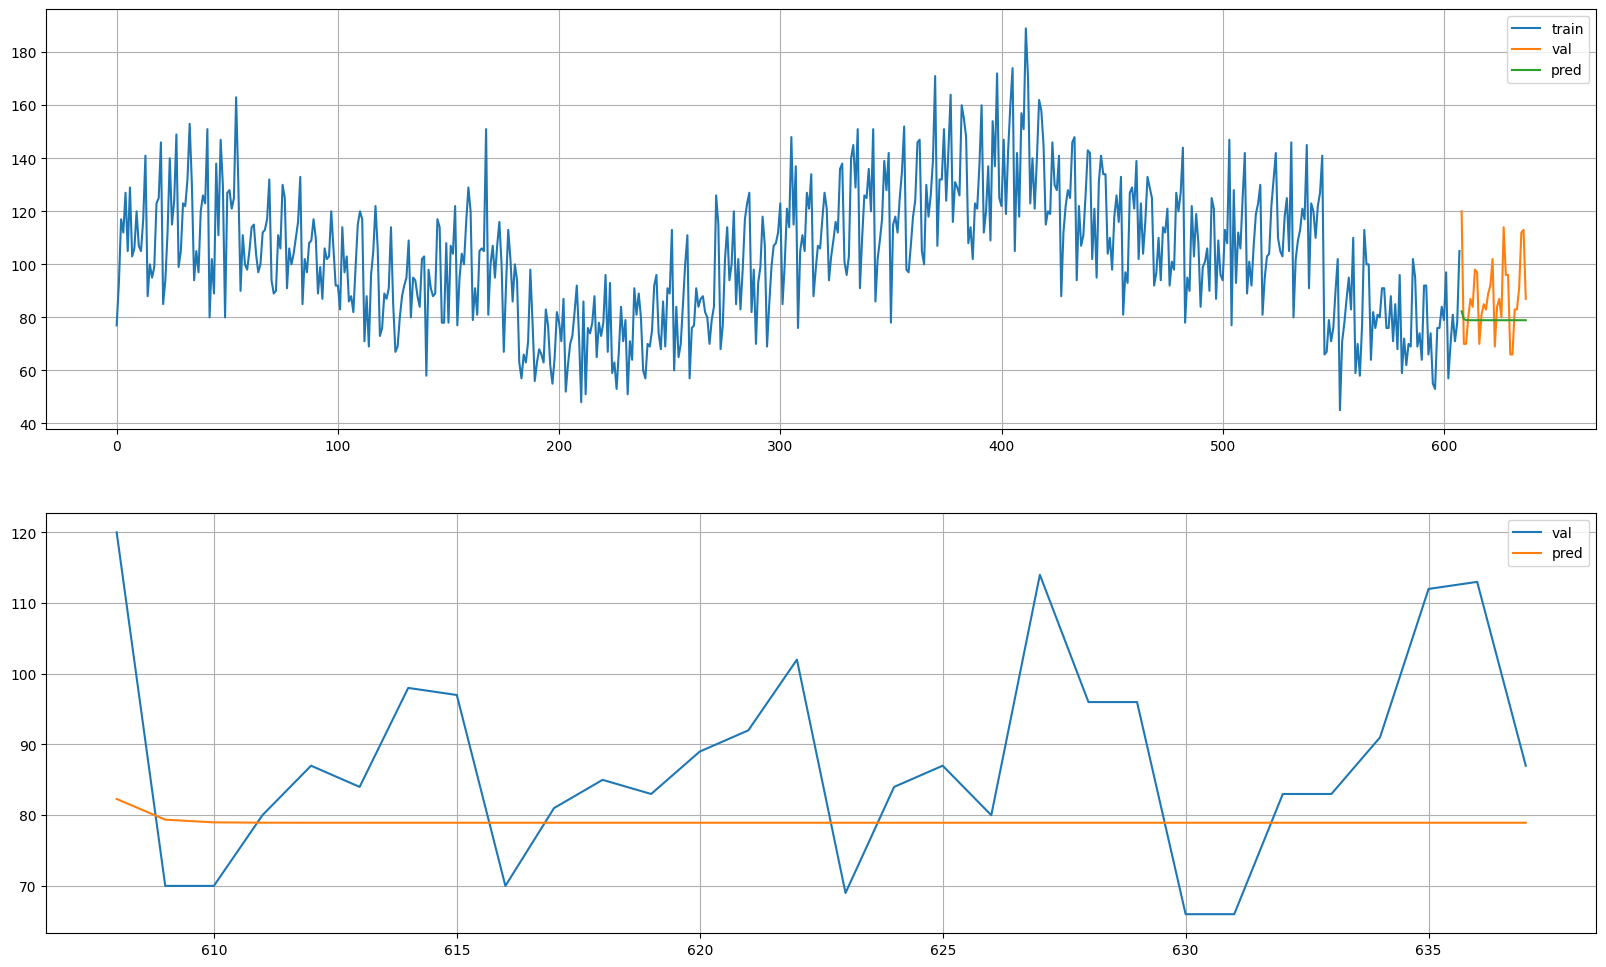

In [ ]:
plot_model_result(y_train, y_val, pred1)

# 4.평가 : 잔차분석

* 잔차에 대한 우리의 기대 : 화이트 노이즈
    * 자기상관성 없음 : ACF, PACF 그래프
    * 정규분포 : Shapiro-Wilk 검정
    * 평균과 분산이 일정(Stationary) : ADF 검정
* 만약 화이트 노이즈가 아니라면...
    * 더 찾아내야 할 패턴이 있다는 의미.

In [ ]:
residuals = model1.resid

* 정규성 검정(> 0.05) :  0.16147
* 정상성 검정(< 0.05) :  1e-05
* 자기상관성 확인(ACF, PACF)


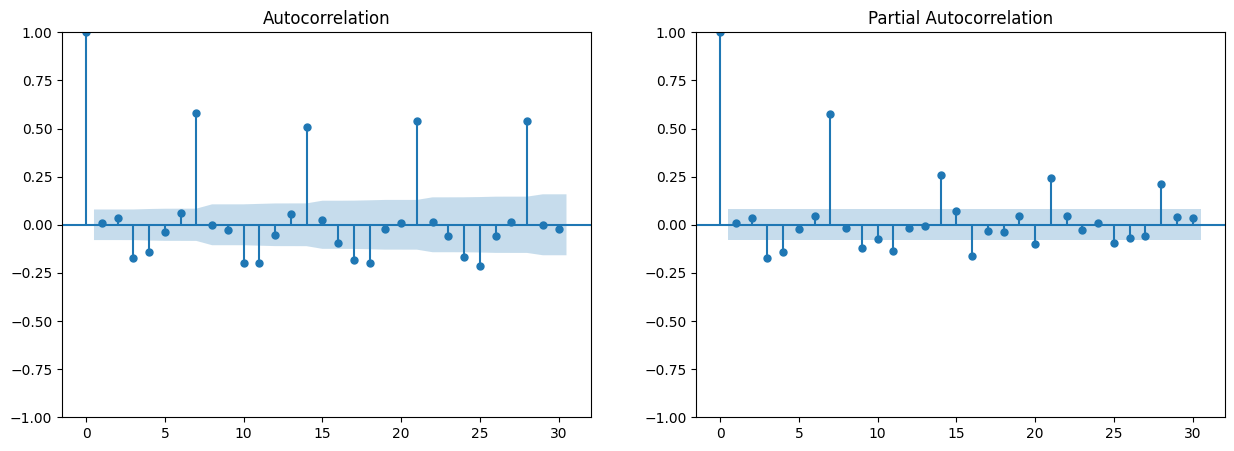

In [ ]:
residual_diag(residuals, lags = 30)